# CPR appropriation

## Pre-requisites

In [70]:
%%capture
!pip install src/gym_cpr_grid
!pip install -r requirements.txt

In [65]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display

from src import models, policies, rllib

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utilities

In [66]:
wandb_api_key = open("./wandb_api_key_file", "r").read().strip()
wandb_project = "cpr-appropriation"

In [67]:
n_agents = 11
grid_width = 39
grid_height = 19
max_steps = 1000
max_episodes = 4000
seed = 42
rllib_log_dir = "./rllib_logs/"

In [72]:
env = gym.make(
    'gym_cpr_grid:CPRGridEnv-v0', 
    n_agents=n_agents, 
    grid_width=grid_width, 
    grid_height=grid_height,
)

## Random

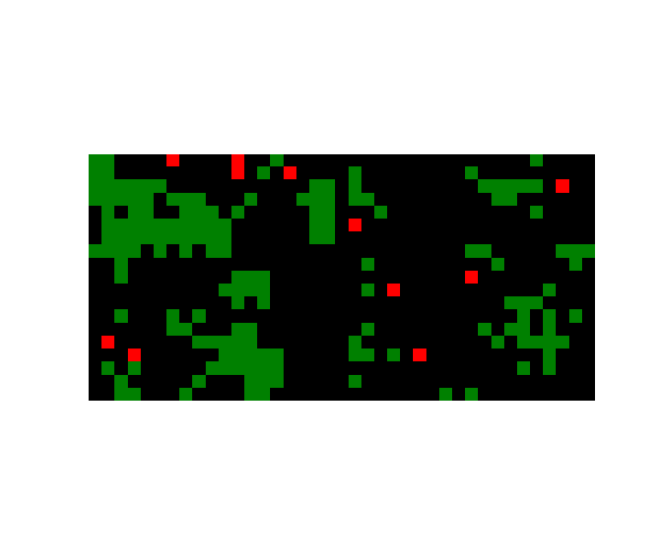

{0: <AgentAction.ROTATE_RIGHT: 5>, 1: <AgentAction.ROTATE_LEFT: 4>, 2: <AgentAction.ROTATE_RIGHT: 5>, 3: <AgentAction.ROTATE_RIGHT: 5>, 4: <AgentAction.STAND_STILL: 6>, 5: <AgentAction.ROTATE_RIGHT: 5>, 6: <AgentAction.GIFT: 8>, 7: <AgentAction.STEP_FORWARD: 0>, 8: <AgentAction.STEP_LEFT: 2>, 9: <AgentAction.STEP_LEFT: 2>, 10: <AgentAction.GIFT: 8>}


KeyboardInterrupt: 

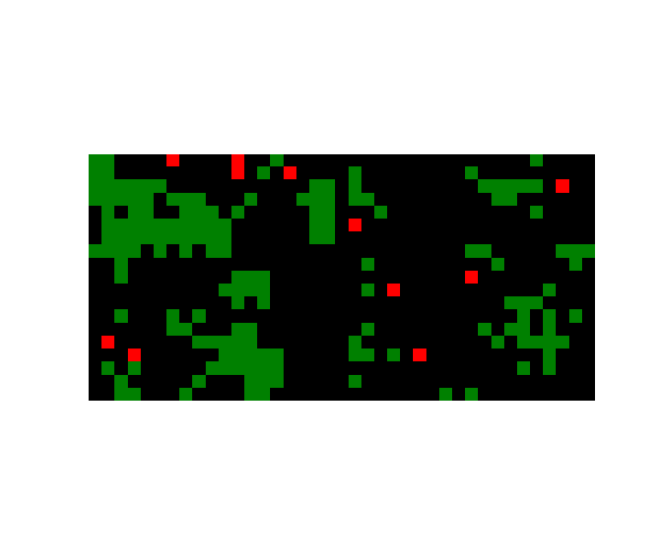

In [73]:
observations = env.reset()
fig, ax, img = env.plot(env.render('rgb_array'))
for _ in range(env.max_steps):
    display.display(plt.gcf())
    action_dict = {h: env.action_space.sample() for h in range(env.n_agents)}
    print(action_dict)
    observations, rewards, dones, infos = env.step(action_dict)
    print(infos)
    display.clear_output(wait=True)
    img.set_data(env.render(mode='rgb_array'))
env.close()

## DQN baseline

### Without tagging

In [37]:
experiment_analysis = rllib.dqn_baseline(
    n_agents,
    grid_width,
    grid_height,
    wandb_project,
    wandb_api_key,
    rllib_log_dir,
    max_episodes,
    max_steps=max_steps,
    tagging_ability=False,
    gifting_mechanism=None,
    num_workers=1,
    jupyter=True,
    seed=seed
)

Trial name,status,loc,episodes,U,E,S,P
DQN_gym_cpr_grid:CPRGridEnv-v0_70c20_00000,TERMINATED,,2,2.45176,0.860419,273.469,nan


2021-08-23 16:36:55,307	INFO tune.py:550 -- Total run time: 52.93 seconds (52.72 seconds for the tuning loop).


### With tagging

In [222]:
experiment_analysis = rllib.dqn_baseline(
    n_agents,
    grid_width,
    grid_height,
    wandb_project,
    wandb_api_key,
    rllib_log_dir,
    max_episodes,
    max_steps=max_steps,
    tagging_ability=True,
    gifting_mechanism=None,
    num_workers=1,
    jupyter=True,
    seed=seed
)

TypeError: dqn_baseline() missing 1 required positional argument: 'max_episodes'

### With gifting

#### Zero sum

In [ ]:
experiment_analysis = rllib.dqn_baseline(
    n_agents,
    grid_width,
    grid_height,
    wandb_project,
    wandb_api_key,
    rllib_log_dir,
    max_episodes,
    max_steps=max_steps,
    tagging_ability=False,
    gifting_mechanism=0,
    num_workers=1,
    jupyter=True,
    seed=seed
)

#### Fixed budget

In [ ]:
experiment_analysis = rllib.dqn_baseline(
    n_agents,
    grid_width,
    grid_height,
    wandb_project,
    wandb_api_key,
    rllib_log_dir,
    max_episodes,
    max_steps=max_steps,
    tagging_ability=False,
    gifting_mechanism=1,
    num_workers=1,
    jupyter=True,
    seed=seed
)

#### Replenishable budget

In [ ]:
experiment_analysis = rllib.dqn_baseline(
    n_agents,
    grid_width,
    grid_height,
    wandb_project,
    wandb_api_key,
    rllib_log_dir,
    max_episodes,
    max_steps=max_steps,
    tagging_ability=False,
    gifting_mechanism=2,
    num_workers=1,
    jupyter=True,
    seed=seed
)

## Policy gradient methods

In [82]:
max_epochs = 1000
checkpoints_path = "./checkpoints"
save_every = 100
wandb_config = {
    "api_key": wandb_api_key,
    "project": wandb_project,
    "entity": "wadaboa",
}

### VPG

In [83]:
vpg_policy_nn = models.MLP(env.observation_space_size(), [32, 32], env.action_space_size())
vpg_baseline_nn = models.MLP(env.observation_space_size(), [32, 32], 1)
vpg_policy = policies.VPGPolicy(env, vpg_policy_nn, baseline_nn=vpg_baseline_nn)
vpg_policy.train(
    max_epochs, 
    save_every=save_every, 
    checkpoints_path=checkpoints_path, 
    wandb_config={**wandb_config, "group": "VPG"}
)

wandb: Currently logged in as: wadaboa (use `wandb login --relogin` to force relogin)


2021-08-23 17:00:21.516 | INFO     | src.policies:train:93 - Epoch 1 / 1000
/Users/jobs/Github/cpr-appropriation/src/models.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.out(x)
2021-08-23 17:00:40.304 | INFO     | src.policies:execute_episode:212 - Early stopping, all agents done
2021-08-23 17:00:58.861 | INFO     | src.policies:execute_episode:212 - Early stopping, all agents done
2021-08-23 17:00:58.867 | INFO     | src.policies:train:105 - Working with a batch size of 22
2021-08-23 17:01:13.539 | INFO     | src.policies:train:93 - Epoch 2 / 1000
2021-08-23 17:01:32.378 | INFO     | src.policies:execute_episode:212 - Early stopping, all agents done
2021-08-23 17:01:51.464 | INFO     | src.policies:execute_episode:212 - Early stopping, all agents done
2021-08-23 17:01:51.470 | INFO     | src.policies:train:105 - Working with a batch size of 22
2021-08-23 17:02:07.115 | INFO     | src.po

KeyboardInterrupt: 

### TRPO

In [154]:
trpo_policy_nn = models.MLP(env.observation_space_size(), [32, 32], env.action_space_size())
trpo_baseline_nn = models.MLP(env.observation_space_size(), [32, 32], 1)
trpo_policy = policies.TRPOPolicy(env, trpo_policy_nn, trpo_baseline_nn, beta=1.0, kl_target=0.01)
trpo_policy.train(
    max_epochs, 
    save_every=save_every, 
    checkpoints_path=checkpoints_path, 
    wandb_config={**wandb_config, "group": "TRPO"}
)

2021-08-23 10:25:23.754 | INFO     | src.policies:train:45 - Epoch 1 / 1
2021-08-23 10:25:23.765 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.532 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.540 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.550 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.559 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.569 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.578 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.588 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.597 | INFO     | src.policies:execute_episode:149 - Early stopping, all age

### PPO

In [166]:
ppo_policy_nn = models.MLP(env.observation_space_size(), [32, 32], env.action_space_size())
ppo_baseline_nn = models.MLP(env.observation_space_size(), [32, 32], 1)
ppo_policy = policies.PPOPolicy(env, ppo_policy_nn, ppo_baseline_nn, c1=1.0, c2=0.0, eps=0.2)
ppo_policy.train(
    max_epochs, 
    save_every=save_every, 
    checkpoints_path=checkpoints_path, 
    wandb_config={**wandb_config, "group": "PPO"}
)

2021-08-23 10:33:56.186 | INFO     | src.policies:train:51 - Epoch 1 / 1
/Users/jobs/Github/cpr-appropriation/src/models.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
2021-08-23 10:33:59.245 | INFO     | src.policies:execute_episode:155 - Early stopping, all agents done
2021-08-23 10:33:59.253 | INFO     | src.policies:execute_episode:155 - Early stopping, all agents done
2021-08-23 10:33:59.265 | INFO     | src.policies:execute_episode:155 - Early stopping, all agents done
2021-08-23 10:33:59.334 | INFO     | src.policies:execute_episode:155 - Early stopping, all agents done
2021-08-23 10:33:59.716 | INFO     | src.policies:execute_episode:155 - Early stopping, all agents done
2021-08-23 10:33:59.724 | INFO     | src.policies:execute_episode:155 - Early stopping, all agents done
2021-08-23 10:33:59.734 | INFO     | src.policies:execute_episode:155 - Early stopping, all agents done
2021-08-23 10:33:59